The quantity of CO2 is determined and described by the chemical term “mole fraction”, defined as the number of carbon dioxide molecules in a given number of molecules of air, after removal of water vapor. For example, 413 parts per million of CO2 (abbreviated as ppm) means that in every million molecules of (dry) air there are on average 413 CO2 molecules.

# **Data Preprocessing**

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau
from helpers import (coerce_into_full_datetime, add_missing_one_year_rows, 
                      plot_column, add_missing_dates, plot_rolling_correlations, 
                      interpret_p_value, plot_lagged_correlations, plot_entire_df)
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import warnings
warnings.filterwarnings('ignore')


# Importation, checks and formatting of station data

In [2]:
df_station = pd.read_csv('data_project - Sheet1.csv')
df_station

year  month  day    decimal  average  ndays  1 year ago  10 years ago  \
0     year      5   19  1974.3795   333.37      5     -999.99       -999.99   
1     year      5   26  1974.3986   332.95      6     -999.99       -999.99   
2     year      6    2  1974.4178   332.35      5     -999.99       -999.99   
3     year      6    9  1974.4370   332.20      7     -999.99       -999.99   
4     year      6   16  1974.4562   332.37      7     -999.99       -999.99   
...    ...    ...  ...        ...      ...    ...         ...           ...   
2626  2024      9   15  2024.7063   421.98      7      418.33        395.24   
2627  2024      9   22  2024.7254   421.71      2      418.28        395.47   
2628  2024      9   29  2024.7445   421.95      4      418.35        395.61   
2629  2024     10    6  2024.7637   422.16      4      418.47        395.73   
2630  2024     10   13  2024.7828   422.62      5      419.56        395.86   

      increase since 1800  
0                   50.40  
1                   50.06  
2                   49.60  
3                   49.65  
4                   50.06  
...                   ...  
2626               145.49  
2627               145.32  
2628               145.56  
2629               145.68  
2630               145.97  

[2631 rows x 9 columns]

In [3]:
invalid_10years = (df_station['10 years ago'] == -999.99).sum()
invalid_10years

np.int64(540)

We can use the information from the other columns to create a valid datetime format.

The 'decimal' column along with the 'day' and 'month' columns can be used to adjust the datetime index accordingly

In [4]:
df_station['year'] = df_station['year'].astype(str).str.strip()
mask = df_station['year'] == 'year'
df_station.loc[mask, 'year'] = df_station.loc[mask, 'decimal'].fillna(0).apply(lambda x: int(float(x)))

In [5]:
df_station.drop(columns = ['decimal'], inplace = True)
df_station = coerce_into_full_datetime(df_station)

In [6]:
invalid_average = (df_station['average'] == -999.99).sum()
invalid_1year = (df_station['1 year ago'] == -999.99).sum()
invalid_10years = (df_station['10 years ago'] == -999.99).sum()

print(invalid_average)
print(invalid_1year)
print(invalid_10years)

18
70
540


We are using the data from the '`1 year ago`' and '`10 years ago`' columns to include and adjust missing datetimes, thus giving us a richer dataframe which would allow us to capture the trend effectively. 

In [7]:
df_station = add_missing_dates(df_station) # using the function to create new rows using the '10 year ago' column
df_station = add_missing_one_year_rows(df_station) # using the function to create new rows using the '1 year ago' column
df_station.drop(df_station[df_station['average'] == -999.99].index, inplace=True)

In [8]:
df_station

average  ndays  1 year ago  10 years ago  increase since 1800
1974-05-19   333.37    5.0     -999.99           NaN                50.40
1974-05-25   332.95    NaN         NaN           NaN                  NaN
1974-05-26   332.95    6.0     -999.99           NaN                50.06
1974-06-01   332.44    NaN         NaN           NaN                  NaN
1974-06-02   332.35    5.0     -999.99           NaN                49.60
...             ...    ...         ...           ...                  ...
2024-09-15   421.98    7.0      418.33        395.24               145.49
2024-09-22   421.71    2.0      418.28        395.47               145.32
2024-09-29   421.95    4.0      418.35        395.61               145.56
2024-10-06   422.16    4.0      418.47        395.73               145.68
2024-10-13   422.62    5.0      419.56        395.86               145.97

[5174 rows x 5 columns]

# Importation, preprocessing and evaluation of feature importance from Open Meteo weather data

In [9]:
df_history = pd.read_csv(r'open-meteo-19.44N155.62E0m - Sheet1.csv', skiprows=3)
df_history.index = pd.to_datetime(df_history.index).strftime('%Y-%m-%d %H:%M:%S')
df_history.reset_index(inplace=True)
df_history.set_index('time', inplace=True)
df_history.drop(columns = 'index', inplace = True)
df_history.index = pd.to_datetime(df_history.index)
df_history = df_history.resample('D').mean()

In [10]:
df_history

temperature_2m (°C)  relative_humidity_2m (%)  dew_point_2m (°C)  \
time                                                                           
1974-05-01            26.391667                 78.666667          22.375000   
1974-05-02            26.612500                 78.500000          22.570833   
1974-05-03            26.275000                 78.625000          22.258333   
1974-05-04            26.266667                 82.041667          22.929167   
1974-05-05            26.454167                 84.375000          23.629167   
...                         ...                       ...                ...   
2024-10-28            27.741667                 61.583333          19.679167   
2024-10-29            27.779167                 70.541667          21.950000   
2024-10-30            27.866667                 72.625000          22.500000   
2024-10-31            27.900000                 77.000000          23.495833   
2024-11-01            27.837500                 77.458333          23.508333   

            precipitation (mm)  pressure_msl (hPa)  surface_pressure (hPa)  \
time                                                                         
1974-05-01            0.000000         1013.758333             1013.758333   
1974-05-02            0.000000         1014.570833             1014.570833   
1974-05-03            0.020833         1014.241667             1014.241667   
1974-05-04            0.041667         1013.062500             1013.062500   
1974-05-05            0.050000         1014.145833             1014.145833   
...                        ...                 ...                     ...   
2024-10-28            0.004167         1012.966667             1012.966667   
2024-10-29            0.016667         1014.754167             1014.754167   
2024-10-30            0.058333         1014.120833             1014.120833   
2024-10-31            0.050000         1013.391667             1013.391667   
2024-11-01            0.020833         1014.066667             1014.066667   

            et0_fao_evapotranspiration (mm)  wind_speed_10m (m/s)  \
time                                                                
1974-05-01                         0.227917              9.143333   
1974-05-02                         0.227500              7.852083   
1974-05-03                         0.226250              6.119583   
1974-05-04                         0.197500              6.208750   
1974-05-05                         0.197500              7.193750   
...                                     ...                   ...   
2024-10-28                         0.241250              4.770417   
2024-10-29                         0.220417              6.972917   
2024-10-30                         0.217917              9.532917   
2024-10-31                         0.193750              7.647083   
2024-11-01                         0.201667              8.111667   

            soil_temperature_0_to_7cm (°C)  
time                                        
1974-05-01                       26.700000  
1974-05-02                       26.933333  
1974-05-03                       27.066667  
1974-05-04                       27.300000  
1974-05-05                       27.466667  
...                                    ...  
2024-10-28                       29.033333  
2024-10-29                       28.941667  
2024-10-30                       28.900000  
2024-10-31                       28.858333  
2024-11-01                       28.820833  

[18448 rows x 9 columns]

In [11]:
# Creating df on dates when station data and Open Meteo data overlap

common_dates = df_history.index.intersection(df_station.index)
df_history = df_history.loc[common_dates]

In [12]:
df_history

temperature_2m (°C)  relative_humidity_2m (%)  dew_point_2m (°C)  \
1974-05-19            25.341667                 70.666667          19.587500   
1974-05-25            26.820833                 83.041667          23.716667   
1974-05-26            26.445833                 81.000000          22.929167   
1974-06-01            26.587500                 81.416667          23.120833   
1974-06-02            26.600000                 80.833333          23.037500   
...                         ...                       ...                ...   
2024-09-15            28.470833                 76.041667          23.812500   
2024-09-22            28.937500                 76.416667          24.341667   
2024-09-29            28.983333                 75.750000          24.245833   
2024-10-06            28.591667                 76.458333          24.045833   
2024-10-13            27.341667                 83.375000          24.279167   

            precipitation (mm)  pressure_msl (hPa)  surface_pressure (hPa)  \
1974-05-19            0.091667         1009.866667             1009.866667   
1974-05-25            0.004167         1014.900000             1014.900000   
1974-05-26            0.012500         1014.766667             1014.766667   
1974-06-01            0.025000         1012.683333             1012.683333   
1974-06-02            0.029167         1011.666667             1011.666667   
...                        ...                 ...                     ...   
2024-09-15            0.425000         1009.612500             1009.612500   
2024-09-22            0.045833         1013.208333             1013.208333   
2024-09-29            0.004167         1013.491667             1013.491667   
2024-10-06            0.095833         1012.320833             1012.320833   
2024-10-13            0.437500         1010.179167             1010.179167   

            et0_fao_evapotranspiration (mm)  wind_speed_10m (m/s)  \
1974-05-19                         0.194583              7.951667   
1974-05-25                         0.213750              5.412083   
1974-05-26                         0.220833              6.092083   
1974-06-01                         0.217500              4.369167   
1974-06-02                         0.208333              3.939167   
...                                     ...                   ...   
2024-09-15                         0.215417              7.975000   
2024-09-22                         0.235833              7.489167   
2024-09-29                         0.232083              6.991667   
2024-10-06                         0.207917              5.662083   
2024-10-13                         0.152500              6.735000   

            soil_temperature_0_to_7cm (°C)  
1974-05-19                       27.300000  
1974-05-25                       27.833333  
1974-05-26                       27.666667  
1974-06-01                       28.033333  
1974-06-02                       28.166667  
...                                    ...  
2024-09-15                       29.450000  
2024-09-22                       29.591667  
2024-09-29                       29.691667  
2024-10-06                       29.608333  
2024-10-13                       29.416667  

[5174 rows x 9 columns]

In [13]:
df_station_column = df_station[['average']]
df_CO2_meteo = df_history.join(df_station_column, how='inner')

## Evaluating correlations between weather data and CO2 levels from station data

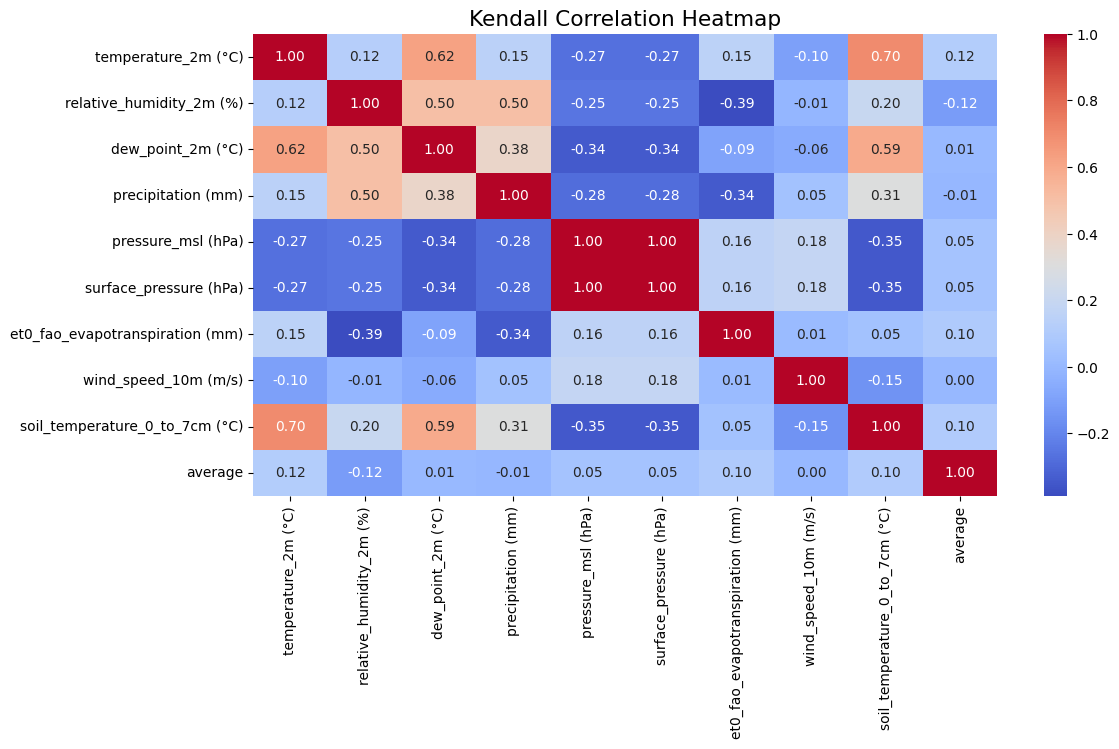

In [14]:
# Computing Kendall's Tau correlation matrix

kendall_corr = df_CO2_meteo.corr(method='kendall')

plt.figure(figsize=(12, 6))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', fmt=".2f")
div_palette = sns.color_palette("RdBu", 12)
plt.rcParams.update({'font.size': 13})
plt.title("Kendall Correlation Heatmap")
plt.show()

Surprisingly and unfortunately, there seems to be little to no correlation between the weather data and the average levels of CO2 at this particular location.

However further testing and assessment is needed before drawing final conclusions.



In [15]:
df_CO2_meteo.drop(['surface_pressure (hPa)'],axis=1,inplace = True)

In [16]:
df_CO2_meteo.rename(columns={'average': 'average_CO2', 'temperature_2m (°C)' : 'temperature', 
                             'relative_humidity_2m (%)':'humidity', 'dew_point_2m (°C)' : 'dew_point',
                             'precipitation (mm)' : 'precipitation', 'pressure_msl (hPa)' : 'pressure',
                             'et0_fao_evapotranspiration (mm)' : 'evapotranspiration', 
                             'wind_speed_10m (m/s)' : 'wind_speed', 'soil_temperature_0_to_7cm (°C)' : 'soil_temperature'}, inplace=True)

In [17]:
df_CO2_meteo.to_csv('df_CO2_meteo.csv', index=True)

# N2O Importation and analysis

In [18]:
df_N2O = pd.read_csv(r'mlo_N2O_Day.csv', skiprows = 1)

In [19]:
df_N2O

N2OcatsMLOyr  N2OcatsMLOmon  N2OcatsMLOday  N2OcatsMLOm  N2OcatsMLOmsd  \
0             1998             11             28          NaN            NaN   
1             1998             11             29          NaN            NaN   
2             1998             11             30          NaN            NaN   
3             1998             12              1          NaN            NaN   
4             1998             12              2          NaN            NaN   
...            ...            ...            ...          ...            ...   
8760          2022             11             23       337.97           1.08   
8761          2022             11             24       337.61           0.98   
8762          2022             11             25       337.51           1.02   
8763          2022             11             26       337.02           0.96   
8764          2022             11             27       337.51           0.94   

      N2OcatsMLOn  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
8760           24  
8761           24  
8762           23  
8763           23  
8764           24  

[8765 rows x 6 columns]

In [20]:
new_column_names = ['year', 'month', 'day', 'median_N2O', 'std._dev.N2O', 'samplesN20']
df_N2O.columns = new_column_names
df_N2O

year  month  day  median_N2O  std._dev.N2O  samplesN20
0     1998     11   28         NaN           NaN           0
1     1998     11   29         NaN           NaN           0
2     1998     11   30         NaN           NaN           0
3     1998     12    1         NaN           NaN           0
4     1998     12    2         NaN           NaN           0
...    ...    ...  ...         ...           ...         ...
8760  2022     11   23      337.97          1.08          24
8761  2022     11   24      337.61          0.98          24
8762  2022     11   25      337.51          1.02          23
8763  2022     11   26      337.02          0.96          23
8764  2022     11   27      337.51          0.94          24

[8765 rows x 6 columns]

In [21]:
df_N2O = coerce_into_full_datetime(df_N2O) # using the `year`, `month` and `day` columns
df_N2O

median_N2O  std._dev.N2O  samplesN20
datetime                                        
1998-11-28         NaN           NaN           0
1998-11-29         NaN           NaN           0
1998-11-30         NaN           NaN           0
1998-12-01         NaN           NaN           0
1998-12-02         NaN           NaN           0
...                ...           ...         ...
2022-11-23      337.97          1.08          24
2022-11-24      337.61          0.98          24
2022-11-25      337.51          1.02          23
2022-11-26      337.02          0.96          23
2022-11-27      337.51          0.94          24

[8765 rows x 3 columns]

In [22]:
df_N2O.interpolate(method='time', inplace=True)
df_N2O.fillna(method='ffill', inplace=True)
df_N2O.fillna(method='bfill', inplace=True)


In [23]:
df_N2O

median_N2O  std._dev.N2O  samplesN20
datetime                                        
1998-11-28      315.59          0.38           0
1998-11-29      315.59          0.38           0
1998-11-30      315.59          0.38           0
1998-12-01      315.59          0.38           0
1998-12-02      315.59          0.38           0
...                ...           ...         ...
2022-11-23      337.97          1.08          24
2022-11-24      337.61          0.98          24
2022-11-25      337.51          1.02          23
2022-11-26      337.02          0.96          23
2022-11-27      337.51          0.94          24

[8765 rows x 3 columns]

# Methane importation and analysis

In [24]:
df_CH4 = pd.read_csv(r'mlo_CH4_Day.csv')

In [25]:
new_column_names = [
    "site_code", "year", "month", "day", "hour", "minute", "second",
    "datetime", "time_decimal", "midpoint_time", "value_CH4", "value_std_dev_CH4",
    "nvalue_CH4", "latitude", "longitude", "altitude", "elevation", "intake_height", "qcflag"
]

df_CH4.columns = new_column_names

df_CH4.drop(
    columns=["site_code", "year", "month", "day", "hour", "minute", "second", "time_decimal",
             "midpoint_time", "latitude", "longitude", "altitude", "elevation", "intake_height", "qcflag"],
    inplace=True
)
df_CH4["datetime"] = pd.to_datetime(df_CH4["datetime"]).dt.date
df_CH4.set_index("datetime", inplace=True)

df_CH4


value_CH4  value_std_dev_CH4  nvalue_CH4
datetime                                            
1987-01-02    -999.99             -99.99           0
1987-01-03    -999.99             -99.99           0
1987-01-04    -999.99             -99.99           0
1987-01-05    -999.99             -99.99           0
1987-01-06    -999.99             -99.99           0
...               ...                ...         ...
2024-04-26    1977.78               0.85           7
2024-04-27    1969.78               2.95           7
2024-04-28    1955.87               7.38           7
2024-04-29    1924.00               0.84           7
2024-04-30    1924.86               0.50           7

[13634 rows x 3 columns]

In [26]:
invalid_CH4 = (df_CH4['value_CH4'] == -999.99).sum()
invalid_CH4

np.int64(906)

Since the invalid rows in this dataset are of a miniscule amount in comparison to the size of the whole data, completely removing them does no harm. 

In [27]:
df_CH4 = df_CH4.loc[df_CH4["value_CH4"] != -999.99]

# SF6 importation and checks

In [28]:
df_SF6 = pd.read_csv(r'mlo_SF6_Day.csv', skiprows = 1)

In [29]:
new_column_names = ['year', 'month', 'day', 'median_SF6', 'std.dev_SF6', 'samples']
df_SF6.columns = new_column_names

In [30]:
df_SF6['year'] = df_SF6['year'].astype(str).str.strip()
mask = df_SF6['year'] == 'year'

df_SF6 = coerce_into_full_datetime(df_SF6) # using the `year`, `month` and `day` columns
df_SF6

median_SF6  std.dev_SF6  samples
datetime                                    
1998-11-29         NaN          NaN        0
1998-11-30         NaN          NaN        0
1998-12-01         NaN          NaN        0
1998-12-02         NaN          NaN        0
1998-12-03         NaN          NaN        0
...                ...          ...      ...
2022-11-23      11.594        0.052       24
2022-11-24      11.518        0.049       24
2022-11-25      11.455        0.047       24
2022-11-26      11.394        0.045       24
2022-11-27      11.405        0.046       24

[8764 rows x 3 columns]

In [31]:
df_SF6.interpolate(method='time', inplace=True)
df_SF6.fillna(method='ffill', inplace=True)
df_SF6.fillna(method='bfill', inplace=True)

# Merging and visualising all data

In [32]:
df_CO2_meteo.rename_axis('datetime', inplace=True)

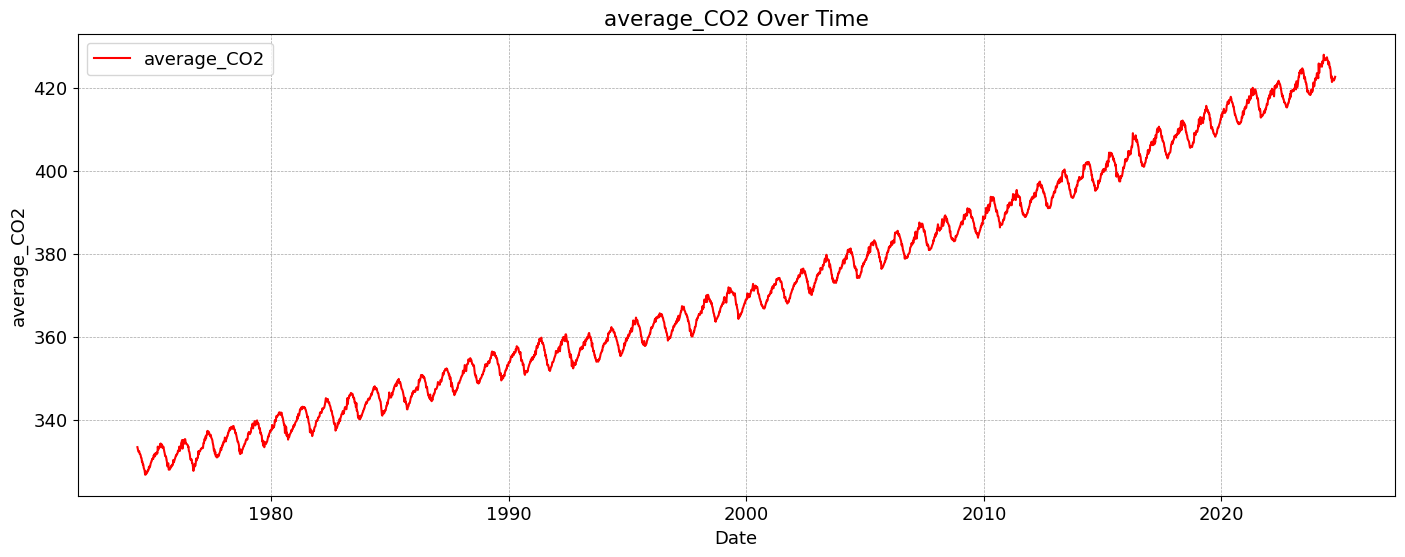

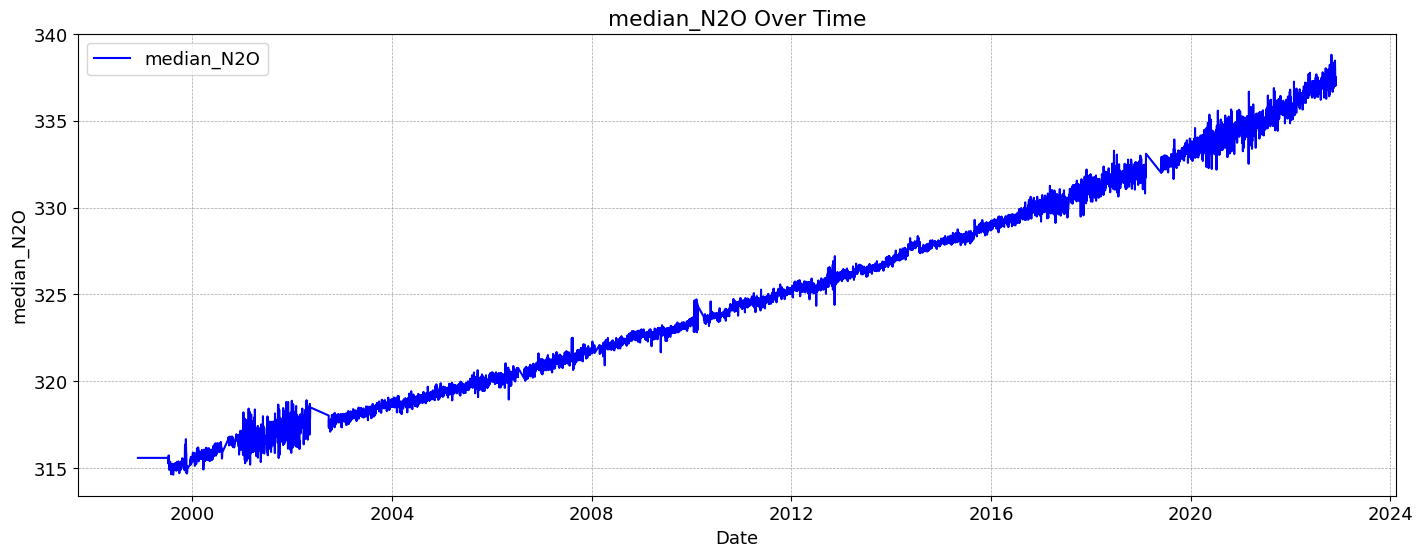

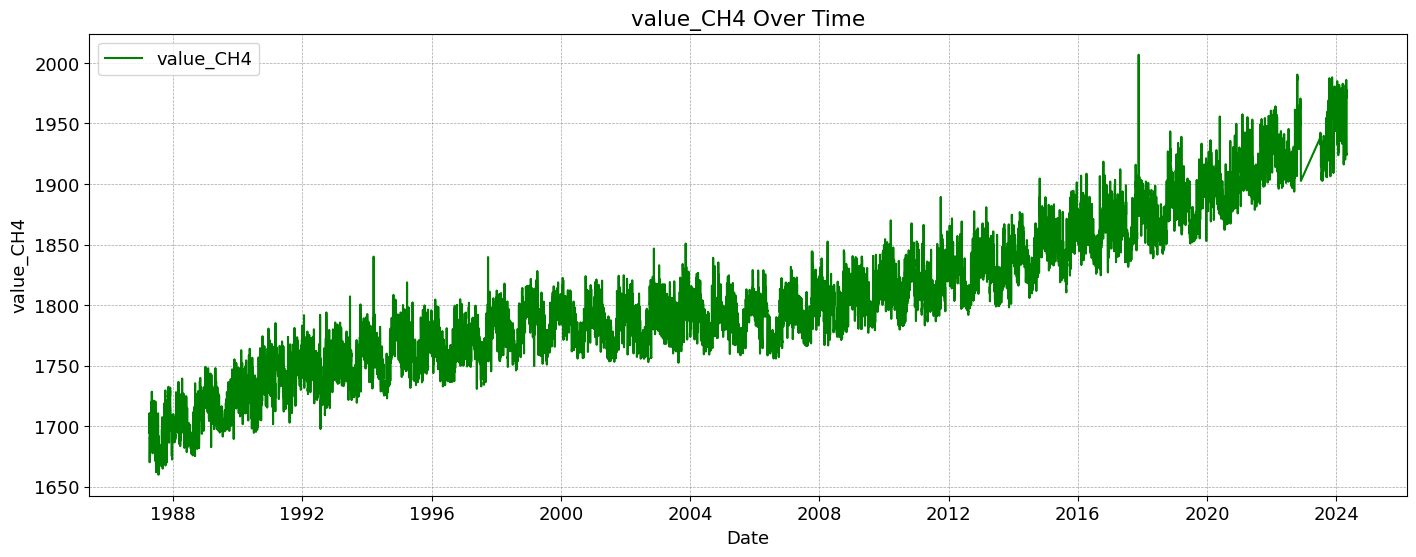

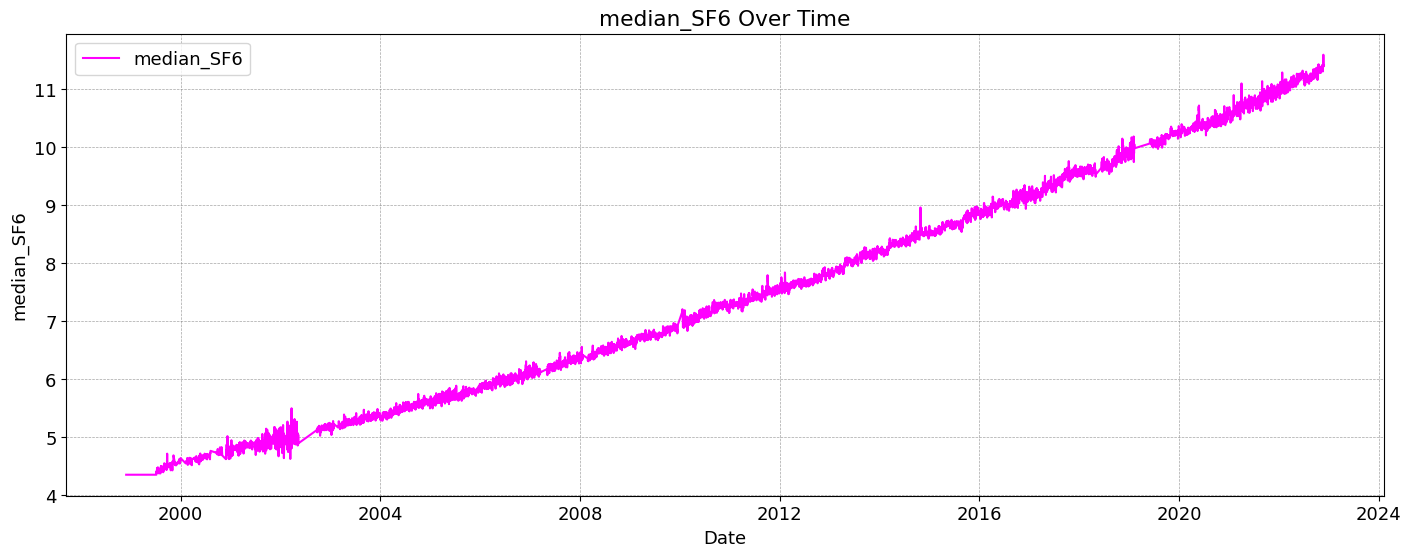

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

In [33]:
plot_column(df_CO2_meteo, 'average_CO2', 'red')
plot_column(df_N2O, 'median_N2O', 'blue')
plot_column(df_CH4, 'value_CH4', 'green')
plot_column(df_SF6, 'median_SF6', 'magenta')
plt.tight_layout

In [34]:
dfs = [df.copy() for df in [df_CO2_meteo, df_N2O, df_CH4, df_SF6]]
for i in range(len(dfs)):
    dfs[i].index = pd.to_datetime(dfs[i].index)  # Converting index to proper datetime64[ns]

start_date = df_CO2_meteo.index.min()  # Get the earliest date from df_CO2_meteo
dfs = [df[df.index >= start_date] for df in dfs]

df_combined_outer = pd.concat(
    [dfs[0][['temperature', 'humidity', 'dew_point', 'precipitation', 'pressure',
             'evapotranspiration', 'wind_speed', 'soil_temperature', 'average_CO2']],
     dfs[1][["median_N2O"]],
     dfs[2][["value_CH4"]],
     dfs[3][["median_SF6"]]],
    axis=1, join="outer")

In [35]:
dfs = [df.copy() for df in [df_CO2_meteo, df_N2O, df_CH4, df_SF6]]
for i in range(len(dfs)):
    dfs[i].index = pd.to_datetime(dfs[i].index)  # Converting index to proper datetime64[ns]

start_date = df_CO2_meteo.index.min()  # Get the earliest date from df_CO2_meteo
dfs = [df[df.index >= start_date] for df in dfs]

df_combined_inner = pd.concat(
    [dfs[0][['temperature', 'humidity', 'dew_point', 'precipitation', 'pressure',
             'evapotranspiration', 'wind_speed', 'soil_temperature', 'average_CO2']],
     dfs[1][["median_N2O"]],
     dfs[2][["value_CH4"]],
     dfs[3][["median_SF6"]]],
    axis=1, join="inner")


In [36]:
columns_to_fill = ['temperature', 'humidity', 'dew_point', 'precipitation', 'pressure',
                   'evapotranspiration', 'wind_speed', 'soil_temperature', 'average_CO2']

df_combined_outer[columns_to_fill] = df_combined_outer[columns_to_fill].interpolate(method='time')
df_combined_outer[columns_to_fill] = df_combined_outer[columns_to_fill].fillna(method='ffill') # Forward fill remaining missing values
df_combined_outer[columns_to_fill] = df_combined_outer[columns_to_fill].fillna(method='bfill') # Backward fill remaining missing values

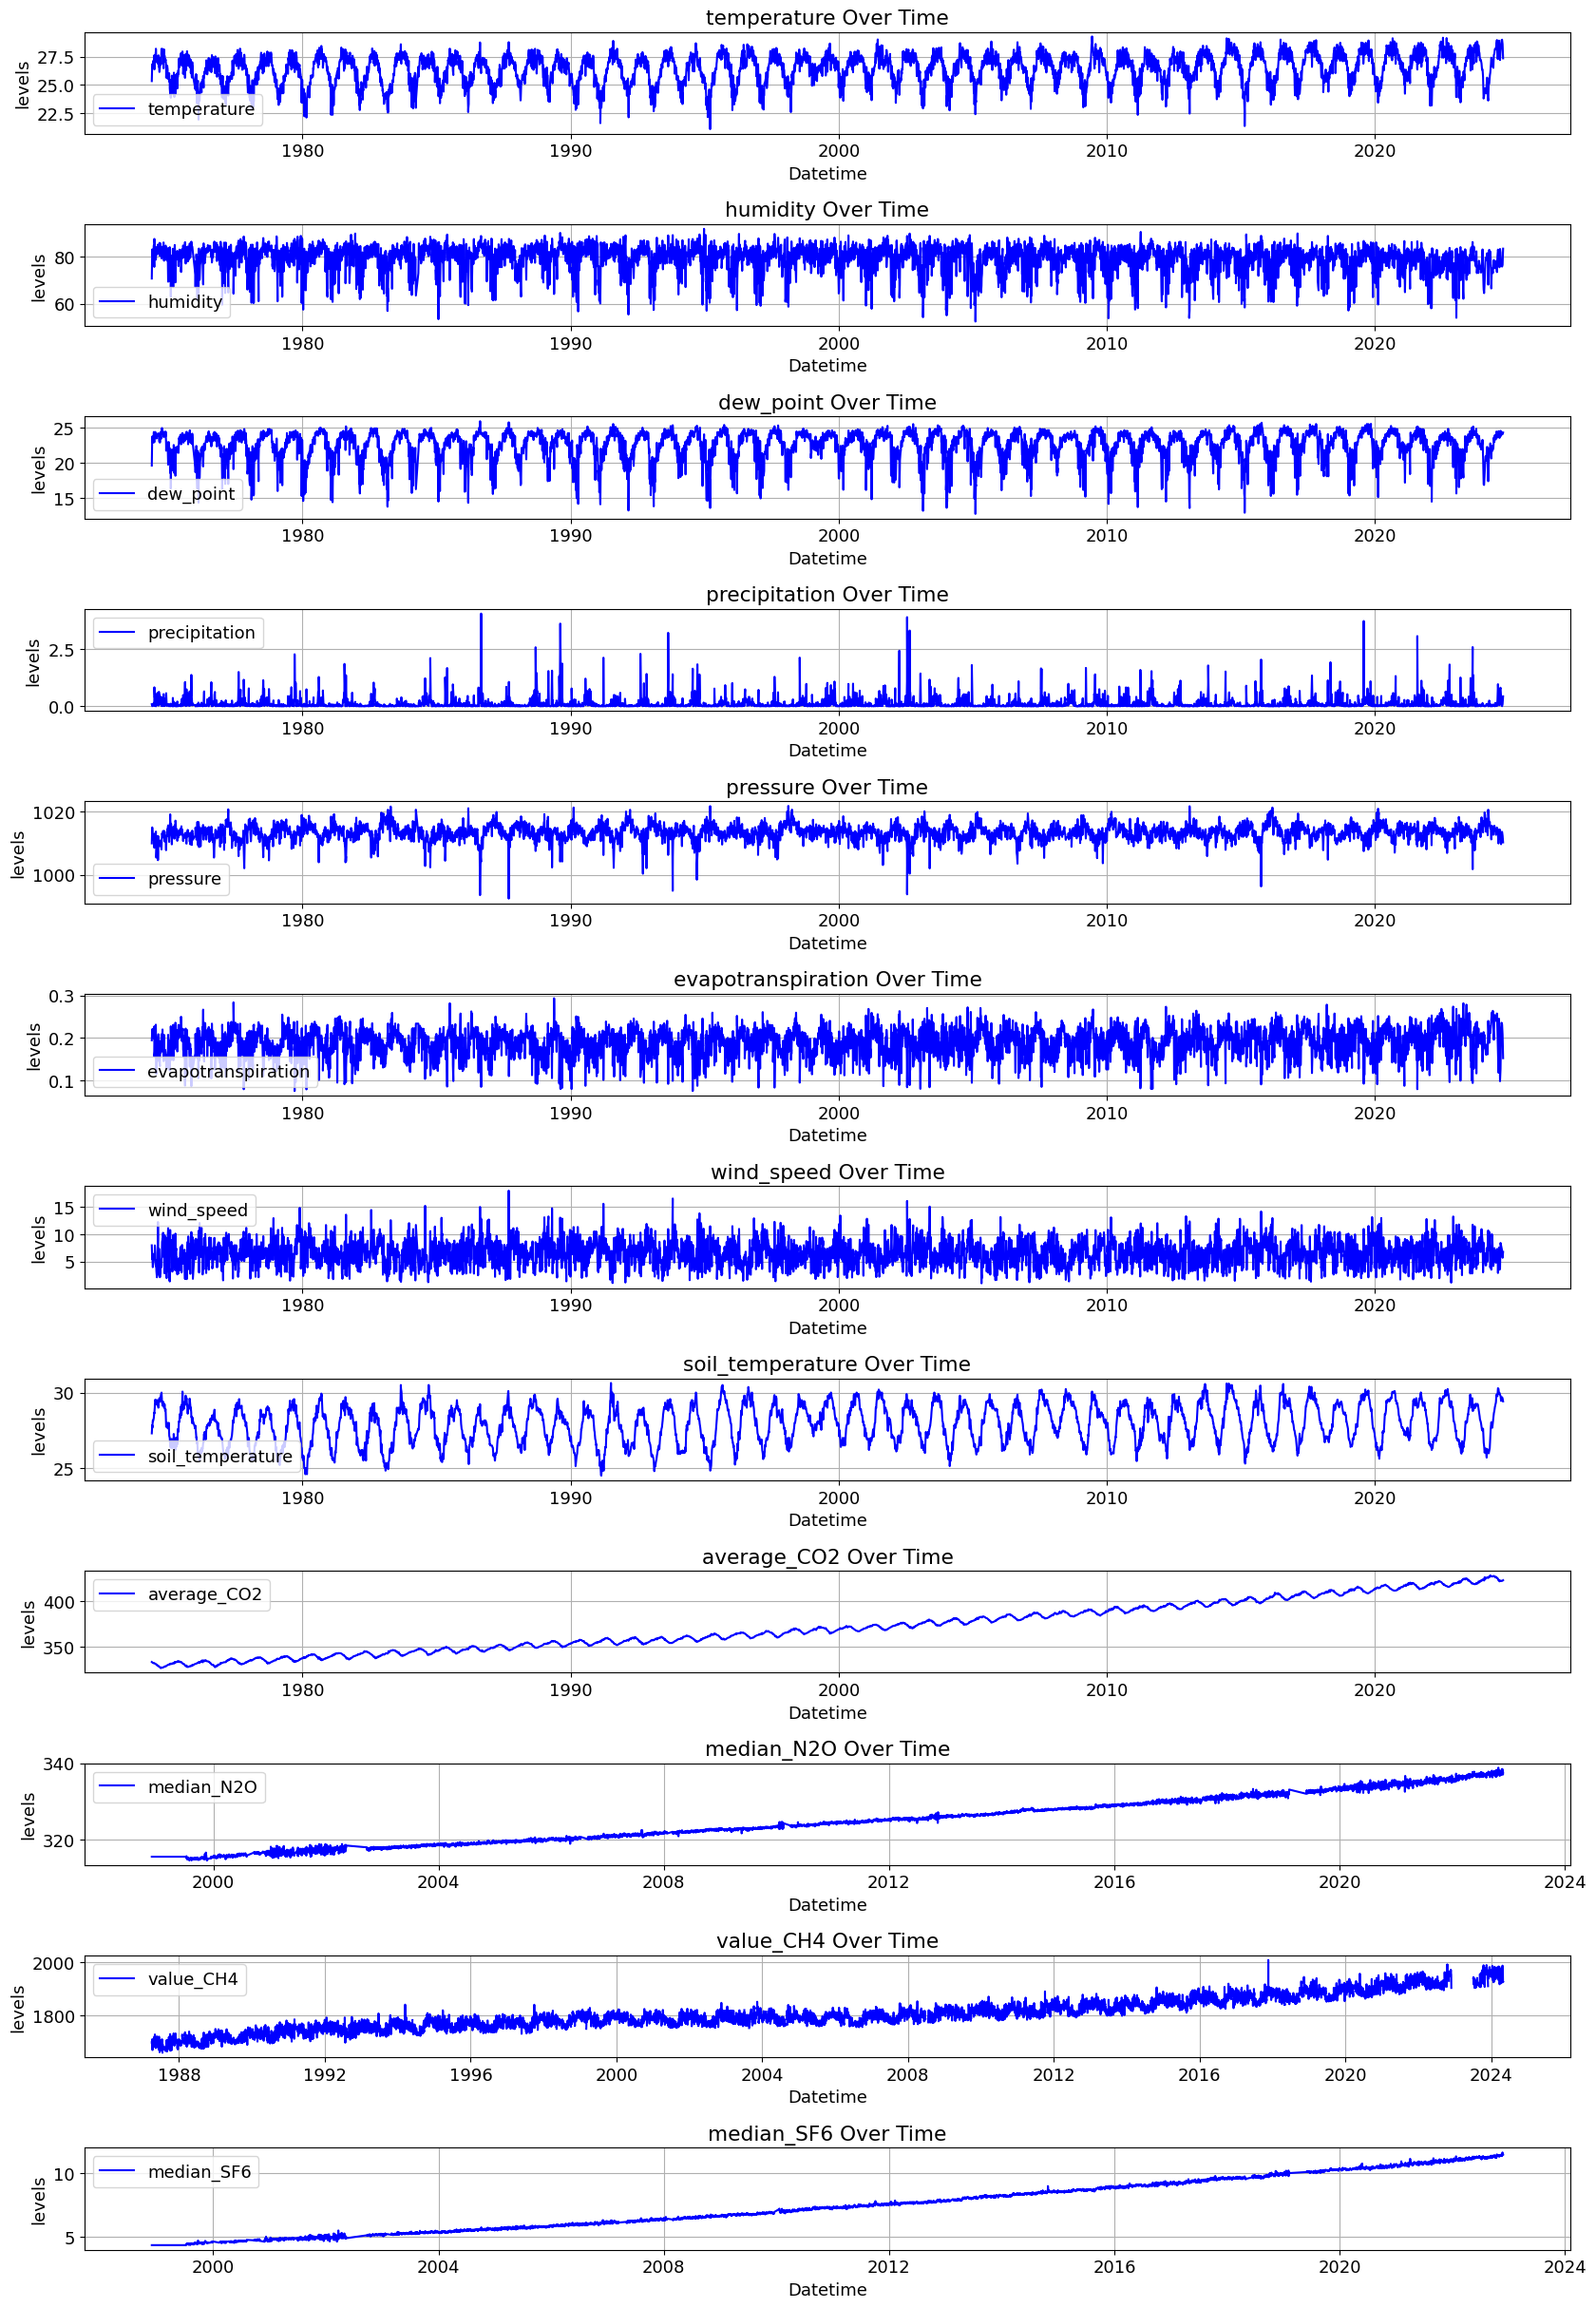

In [37]:
plot_entire_df(df_combined_outer)

# Visualising Correlations 

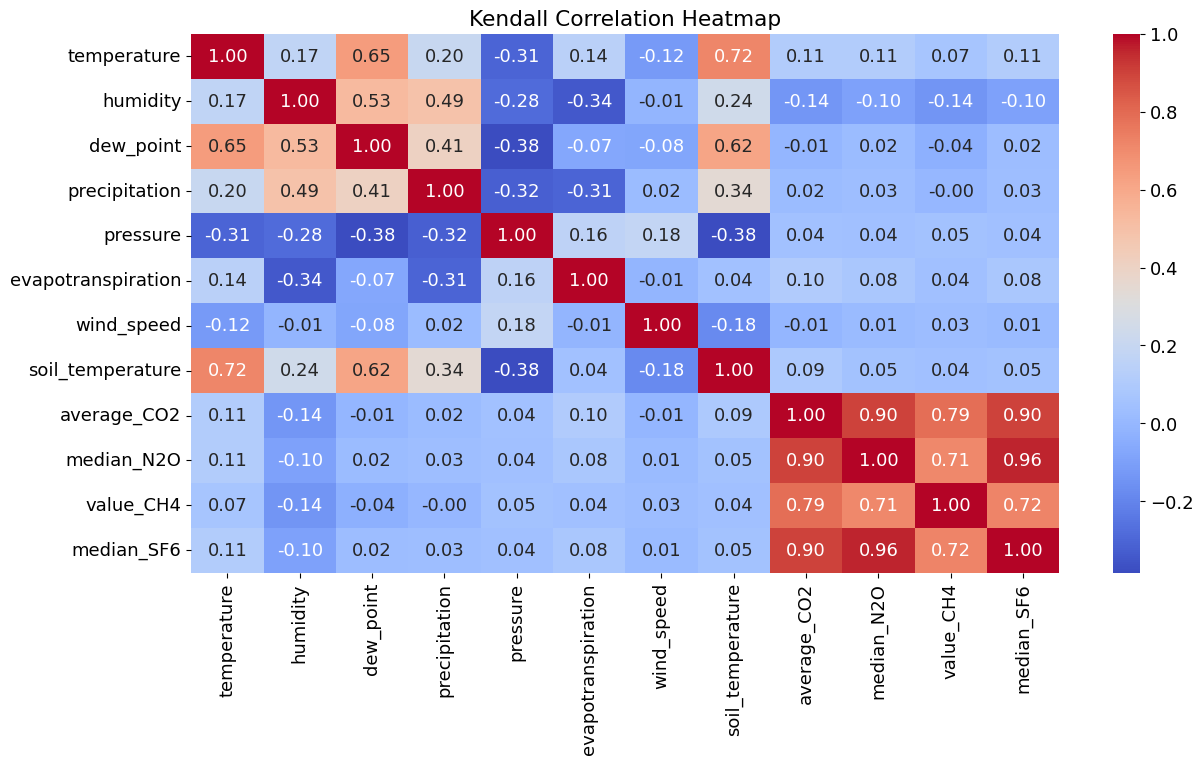

In [38]:
# Computing Kendall's Tau correlation matrix

kendall_corr = df_combined_outer.corr(method='kendall')

plt.figure(figsize=(14, 7))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Kendall Correlation Heatmap")
plt.show()

**Pearson's correlation** measures the linear relationship between variables.

The correlation coefficient ranges from -1 to +1, where -1 indicates a perfect negative linear relationship, +1 indicates a perfect positive linear relationship, and 0 indicates no linear relationship.

However, it has a limitation: it only captures linear relationships and can miss other types of relationships between variables.

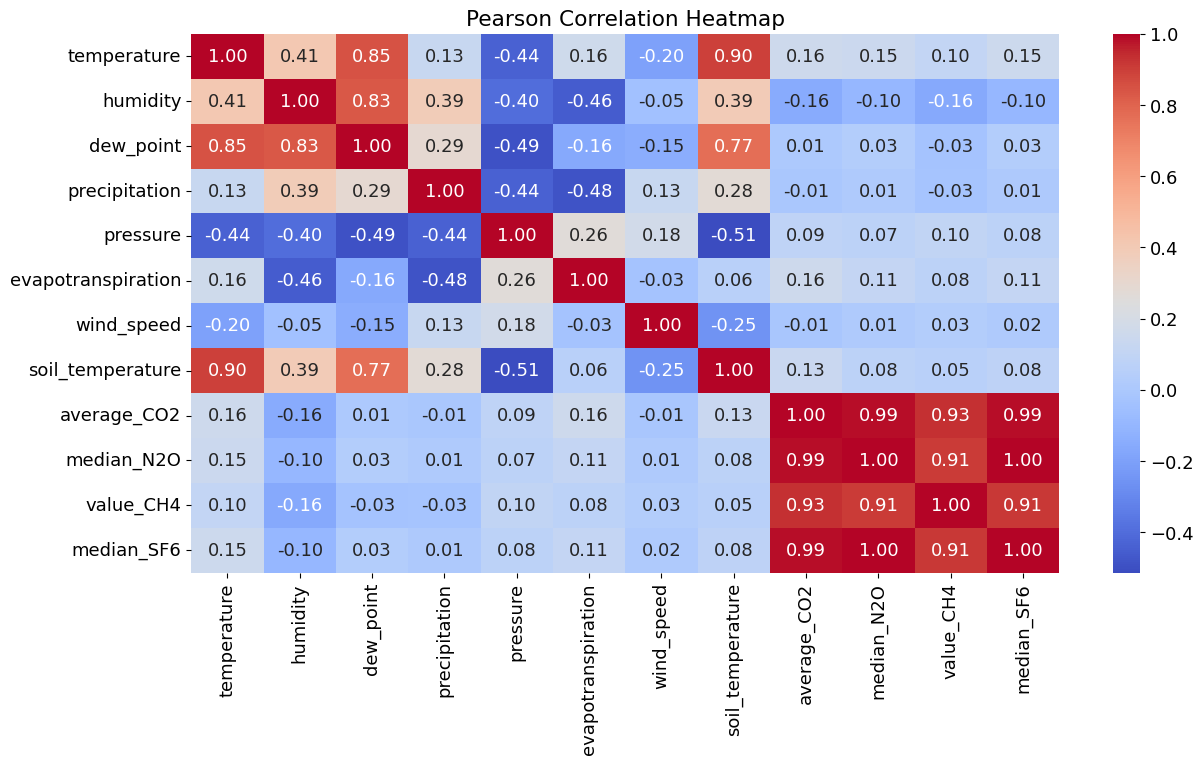

In [39]:
# Compute Pearson's Tau correlation matrix
pearson_corr = df_combined_outer.corr(method='pearson')

plt.figure(figsize=(14, 7))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson Correlation Heatmap")
plt.show()

**Kendall's Tau** takes a different approach. Instead of measuring linear relationships, it looks at the concordance between variables - essentially, whether they tend to move in the same direction. It's measuring the tendency of the variables to increase or decrease together, without assuming anything about the shape of that relationship.

In the context of environmental data like CO2 levels, temperature, and other climate variables, Kendall's Tau might be particularly useful because environmental relationships aren't always linear, and the data often contains outliers or follows non-normal distributions.

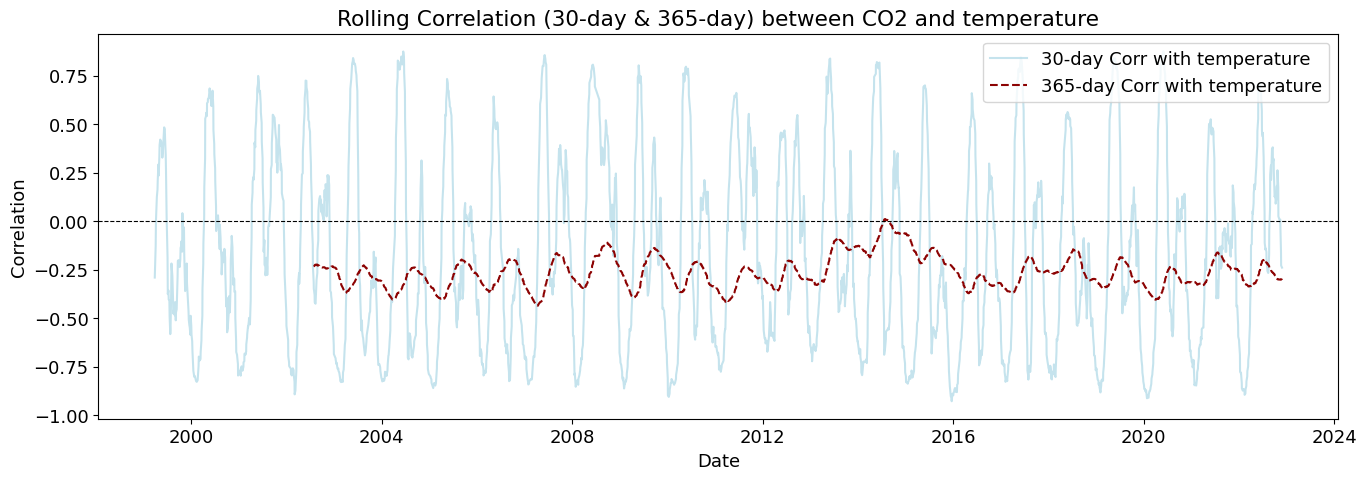

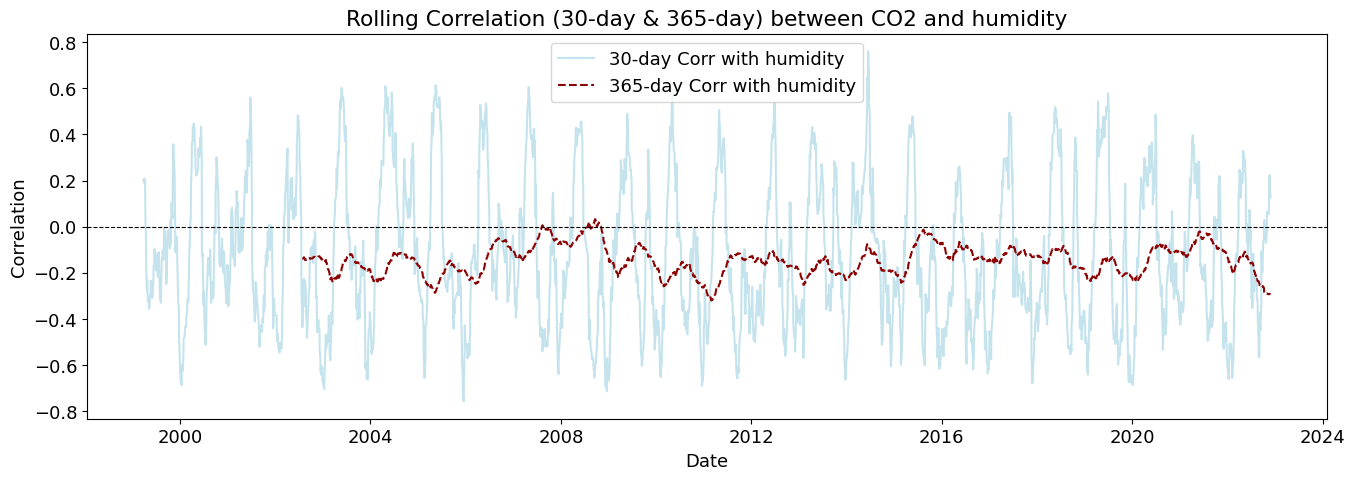

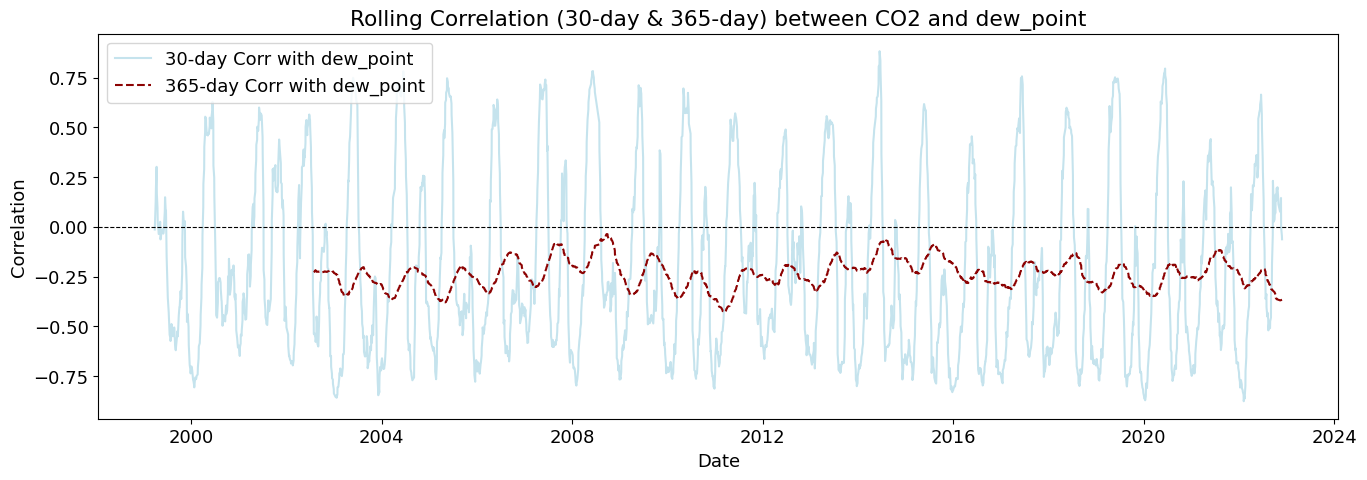

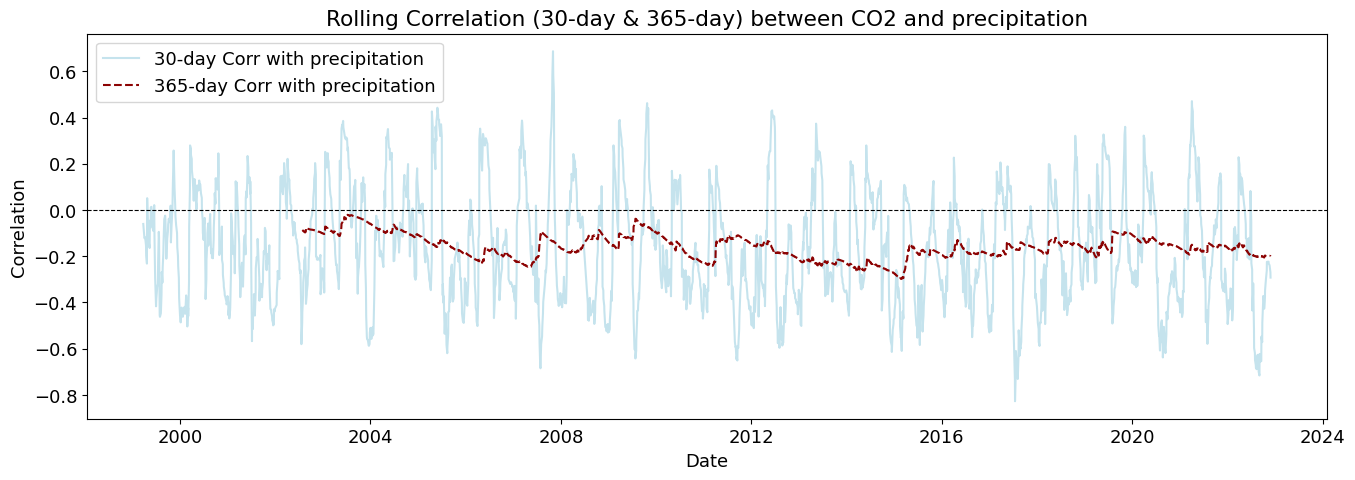

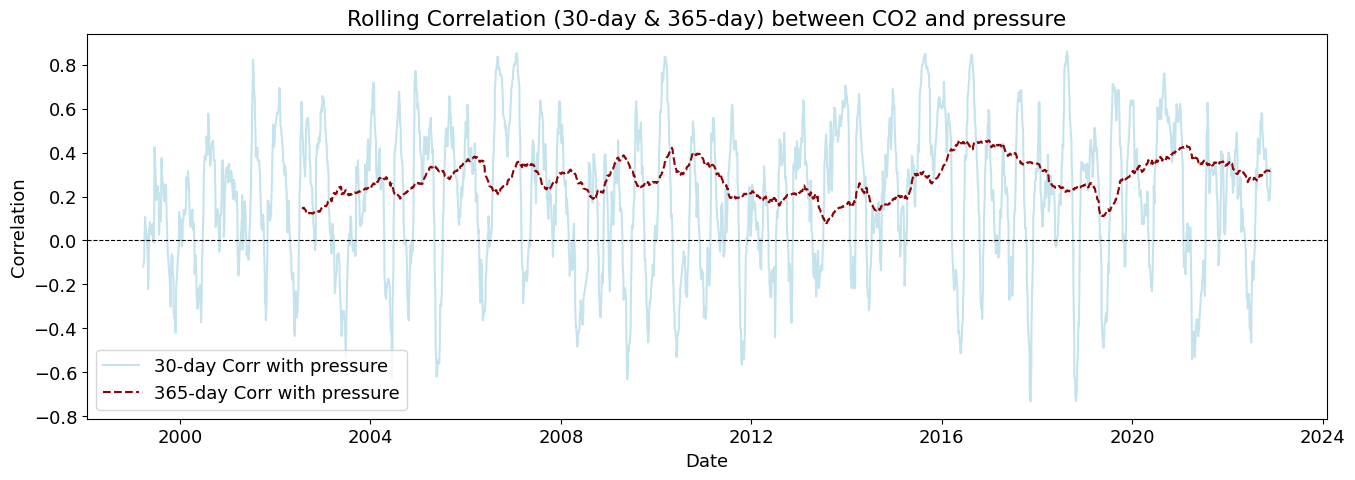

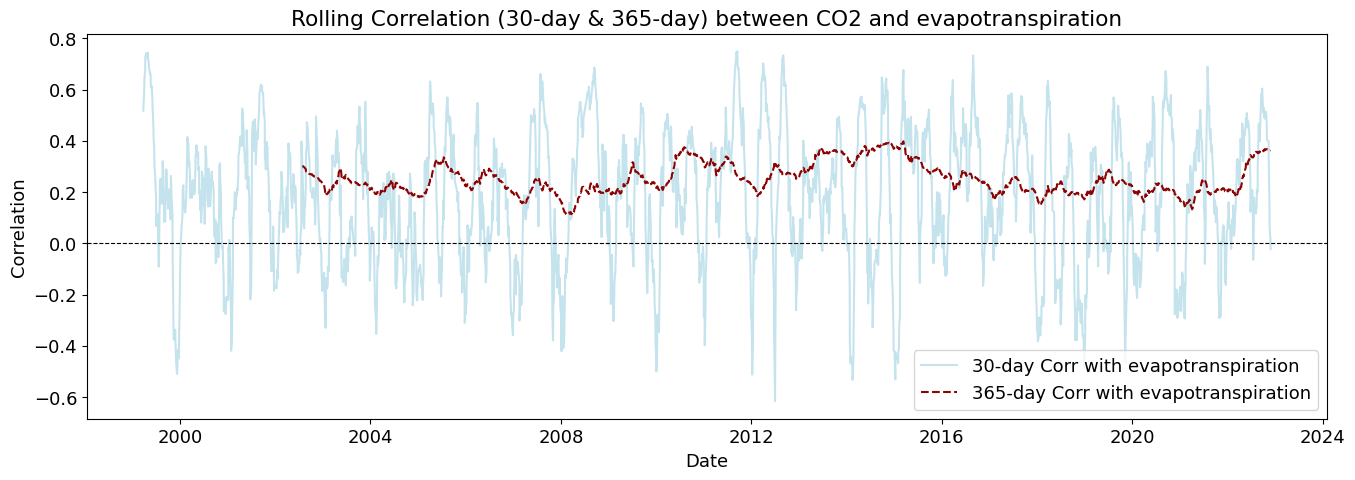

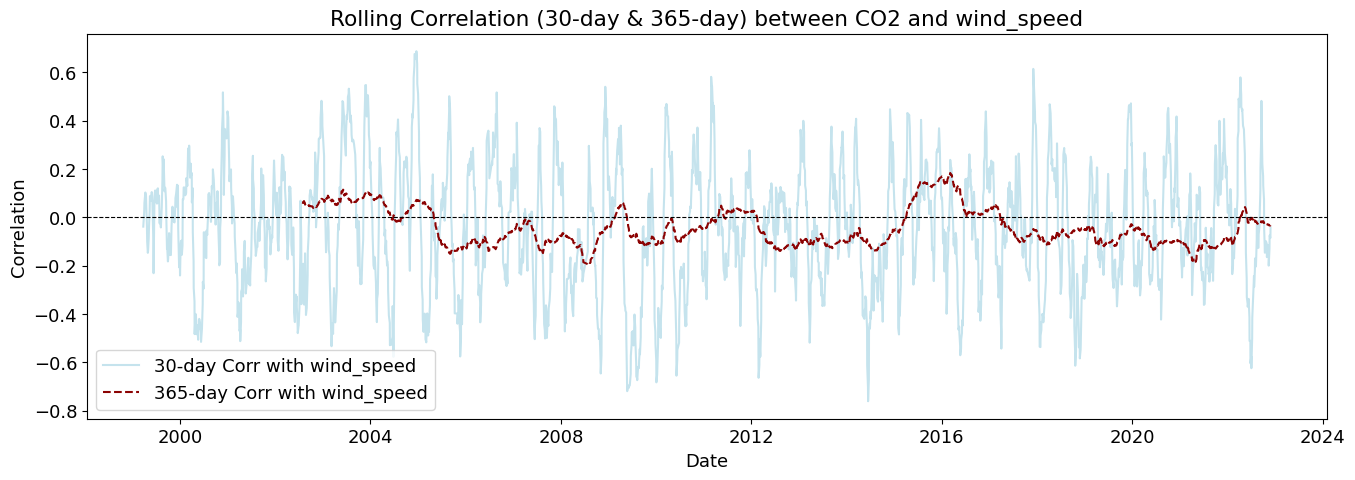

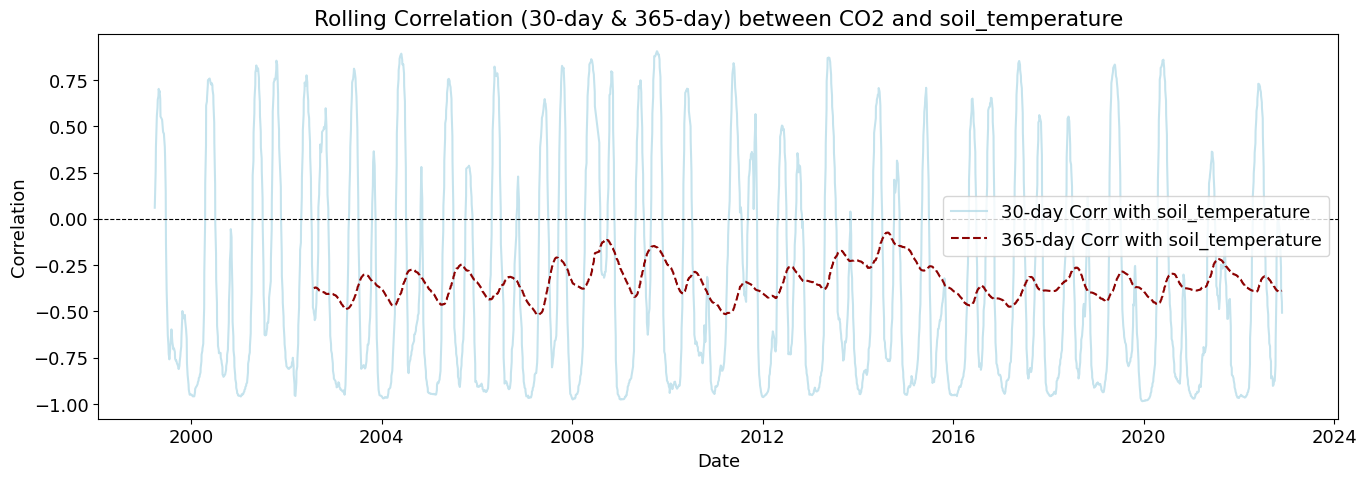

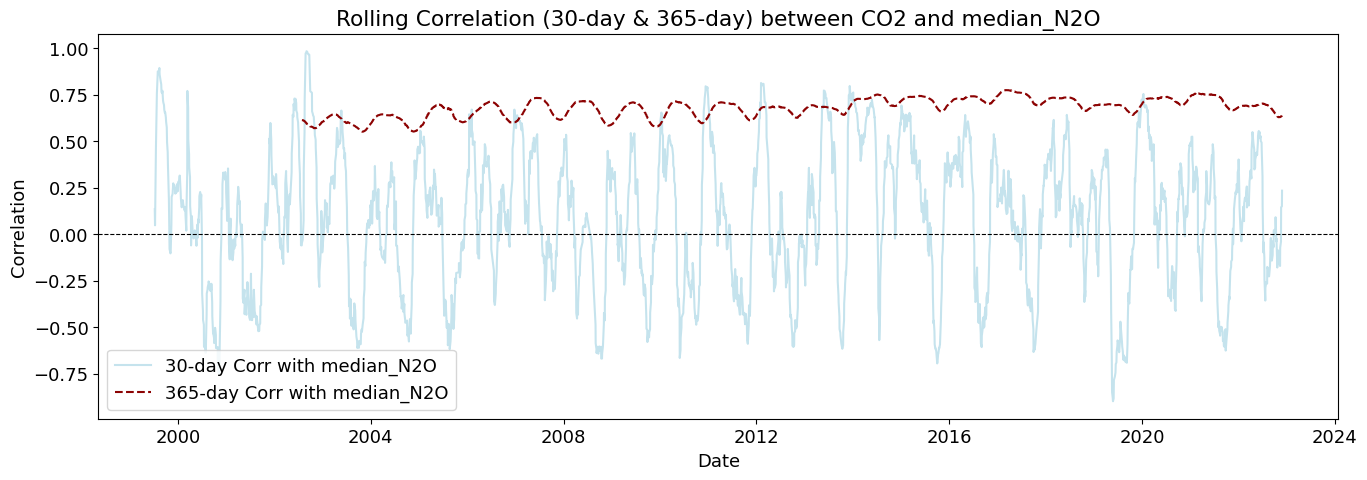

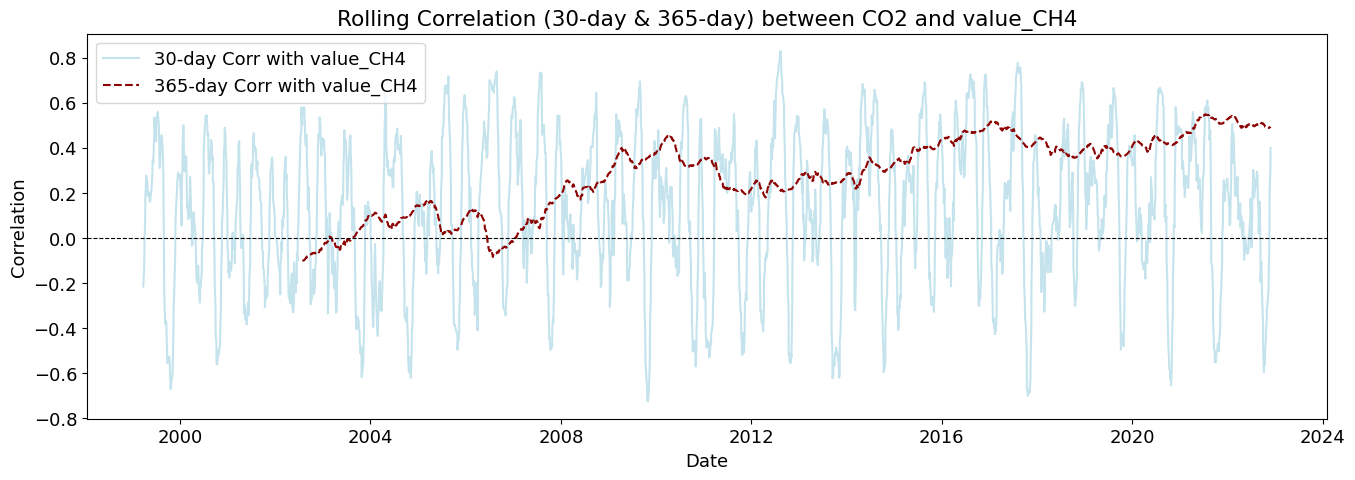

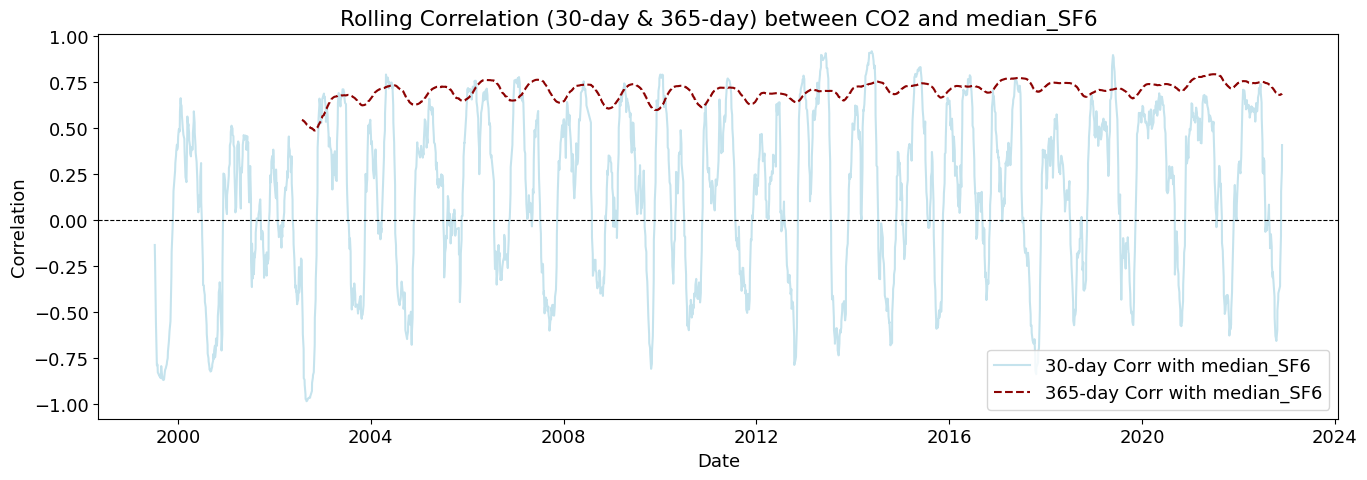

In [40]:
plot_rolling_correlations(df_combined_inner)

**Rolling correlations** (also called *moving correlations*) are a dynamic way to measure how the relationship between two variables changes over time. Unlike a single correlation coefficient that shows one number for an entire dataset, rolling correlations show how the correlation evolves throughout a time series.

Rolling correlations can be used in environmental studies to understand how relationships between variables shift with seasonal or long-term changes. 

In [ ]:
# Checking for stationarity (Augmented Dickey-Fuller Test)
def check_stationarity(series, variable_name):
    result = adfuller(series.dropna())
    p_value = result[1]
    return p_value

stationarity_results = {col: check_stationarity(df_combined_inner[col], col) for col in df_combined_inner.columns}

max_lag = 12
granger_results = {}

# Performing Granger Causality tests
for col in df_combined_inner.columns:
    if col != "average_CO2":
        test_result = grangercausalitytests(df_combined_inner[['average_CO2', col]].dropna(), max_lag, verbose=False)
        granger_results[col] = {lag: test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)}

stationarity_results


{'temperature': np.float64(9.451145188179234e-22),
 'humidity': np.float64(1.2067943715819874e-12),
 'dew_point': np.float64(1.2150381839441513e-19),
 'precipitation': np.float64(7.824982759354124e-20),
 'pressure': np.float64(6.824231580012553e-12),
 'evapotranspiration': np.float64(5.673478319719433e-14),
 'wind_speed': np.float64(8.298941795111292e-30),
 'soil_temperature': np.float64(1.6253595748496084e-23),
 'average_CO2': np.float64(0.8630583937959493),
 'median_N2O': np.float64(0.999004879583799),
 'value_CH4': np.float64(0.6729054440779778),
 'median_SF6': 1.0}

The **ADF test** checks whether a time series data is stationary, which is crucial for many statistical analyses. A stationary time series has consistent statistical properties over time - its mean and variance don't change. 

**Granger Causality tests** explore whether past values of one variable help predict future values of another. It's testing the *"statistical causality"* - though it's important to note that Granger causality doesn't necessarily mean actual causation.

In [42]:
# Converting Granger causality test results into a readable dataFrame

granger_df = pd.DataFrame.from_dict(
    {var: [granger_results[var][lag] for lag in range(1, max_lag + 1)] for var in granger_results.keys()},
    orient='index',
    columns=[f'Lag {i}' for i in range(1, max_lag + 1)]
)

granger_df["Interpretation"] = granger_df.apply(lambda row: interpret_p_value(row.values), axis=1)
granger_df

Lag 1         Lag 2         Lag 3         Lag 4  \
temperature         7.720947e-25  5.497089e-21  7.705556e-26  9.829507e-24   
humidity            8.903531e-12  1.981891e-10  8.968556e-14  2.988373e-14   
dew_point           8.067610e-25  4.458532e-21  8.264431e-26  3.584386e-24   
precipitation       3.819164e-04  5.001872e-03  5.371408e-04  1.094697e-04   
pressure            4.438619e-11  7.971067e-09  1.926409e-10  6.537783e-09   
evapotranspiration  2.125455e-04  1.541215e-05  3.031203e-07  2.011486e-06   
wind_speed          1.440207e-12  4.899939e-12  5.808182e-14  3.671966e-15   
soil_temperature    4.069728e-32  1.903884e-26  1.176250e-39  1.926643e-37   
median_N2O          8.008445e-05  4.118513e-05  8.078303e-04  6.303455e-04   
value_CH4           6.094348e-06  1.821082e-13  1.783052e-19  2.951395e-22   
median_SF6          8.433207e-04  2.402066e-07  7.523613e-06  7.130874e-08   

                           Lag 5         Lag 6         Lag 7         Lag 8  \
temperature         7.675065e-19  3.120083e-17  8.219184e-13  2.203910e-12   
humidity            3.172161e-11  6.171779e-10  6.195866e-07  1.348078e-06   
dew_point           1.393978e-19  4.411318e-18  1.616901e-13  7.524441e-13   
precipitation       8.476688e-03  2.857322e-02  3.756680e-01  5.216954e-01   
pressure            1.693316e-06  1.212028e-05  1.613346e-03  3.624291e-03   
evapotranspiration  3.167283e-08  8.742475e-10  4.830566e-09  1.208496e-08   
wind_speed          1.207507e-13  1.313350e-12  3.845556e-10  5.768298e-10   
soil_temperature    1.831168e-32  1.178714e-30  7.919387e-24  3.344132e-23   
median_N2O          1.439309e-04  3.025065e-06  1.612906e-08  1.365409e-08   
value_CH4           2.037874e-23  3.249063e-25  1.223335e-22  4.499614e-22   
median_SF6          2.532144e-11  1.648528e-12  6.471290e-15  7.232538e-15   

                           Lag 9        Lag 10        Lag 11        Lag 12  \
temperature         5.638884e-10  4.525774e-09  1.018310e-07  2.367689e-07   
humidity            5.218207e-04  2.136951e-03  4.108305e-03  6.423288e-03   
dew_point           4.799498e-09  3.827182e-08  1.586932e-07  3.114832e-07   
precipitation       9.136631e-01  8.859372e-01  3.525676e-01  1.535244e-01   
pressure            2.254627e-02  3.287454e-02  9.963901e-03  7.508465e-03   
evapotranspiration  1.646039e-08  2.601857e-09  6.520648e-12  1.285255e-12   
wind_speed          1.274597e-08  2.401023e-08  1.356298e-07  6.914299e-08   
soil_temperature    6.174720e-22  7.789451e-21  5.191957e-22  2.197068e-21   
median_N2O          6.937741e-13  4.135353e-14  9.966893e-18  1.458885e-18   
value_CH4           6.773017e-15  8.673936e-14  5.394487e-13  1.508888e-12   
median_SF6          5.658483e-17  3.503844e-18  1.710563e-20  1.563221e-22   

                                                       Interpretation  
temperature                               Strong causality (p < 0.01)  
humidity                                  Strong causality (p < 0.01)  
dew_point                                 Strong causality (p < 0.01)  
precipitation       Moderate to low causality (p < 0.05 at some lags)  
pressure            Moderate to low causality (p < 0.05 at some lags)  
evapotranspiration                        Strong causality (p < 0.01)  
wind_speed                                Strong causality (p < 0.01)  
soil_temperature                          Strong causality (p < 0.01)  
median_N2O                                Strong causality (p < 0.01)  
value_CH4                                 Strong causality (p < 0.01)  
median_SF6                                Strong causality (p < 0.01)

 Results
1. Stationarity Check (Augmented Dickey-Fuller Test)
CO₂ (`average_C2O`) is non-stationary → This means CO₂ has a trend and may need differencing to make it stationary before modeling.
Although the meteorological data is mostly stationary, the gas related datasets (`N₂O`, `CH₄`, and `SF₆`) are non-stationary.

2. Granger Causality (p-values across 1-12 lags)
Lower p-values (< 0.05) indicate strong causality.
The smaller the p-value, the more significant the predictive relationship.

- **Temperature** (`temperature_2m (°C)`)	✅ Strong causality across all lags - Predicts future CO₂ trends
- **Relative Humidity** (`relative_humidity_2m (%)`)	✅ Significant up to lag 12 - Influences CO₂ levels, but weaker than temperature
- **N₂O** (`median_N2O`)	✅ Significant causality at longer lags - Has a delayed effect on CO₂
- **CH₄** (`value_CH4`)	✅ Very strong causality - CH₄ changes predict CO₂ variations
- **SF₆** (`median_SF6`)	✅ Moderate causality at higher lags - SF₆ shows long-term predictive power

Temperature and CH₄ have a very strong causal effect and are the strongest predictor of CO₂

The p-values are extremely low, suggesting that past temperature values contain significant information about future CO₂ levels.

This makes sense since methane (CH₄) and CO₂ are both greenhouse gases affected by similar processes.

Humidity, N₂O, and SF₆ also predict CO₂, but to a lesser extent.

______________________________________________________________________________________________________________________________________________________________________________

Why Did Pearson & Kendall Show Weak Correlation, But Granger Shows Strong Causality?
The difference comes from how these methods analyze relationships.

1. *Pearson/Kendall Correlation* (Static, Instantaneous Relationship)
These methods only measure direct relationships between variables at the same time.
Pearson Correlation checks linear relationships at one point in time.
Kendall Correlation looks at rank-based (monotonic) relationships but still without considering time delays.
Since CO₂, temperature, and humidity might have delayed effects on each other, Pearson/Kendall may fail to detect a strong relationship.

2. *Granger Causality* (Temporal Dependency)
This test considers past values of temperature, humidity, and other variables to see if they help predict future CO₂.
Many climate and atmospheric processes do not act immediately—they take weeks or months to show an impact.
Example: Higher temperatures today might increase plant respiration or ocean CO₂ release over the next few weeks or months.
That’s why even if Pearson/Kendall showed weak relationships, Granger Causality detects delayed effects that standard correlation ignores.


Real-World Example of Delayed Causality in Climate Data

Temperature & CO₂: When temperatures rise, it may take weeks to months before we see a significant change in CO₂ levels due to ocean-atmosphere exchange.
Humidity & CO₂: Humidity affects cloud cover, precipitation, and soil moisture, which influence carbon absorption and release but not immediately.
Methane (CH₄) & CO₂: CH₄ breaks down into CO₂ over time, meaning its effects on CO₂ might appear after several months.


### 1 year in the past - analysis

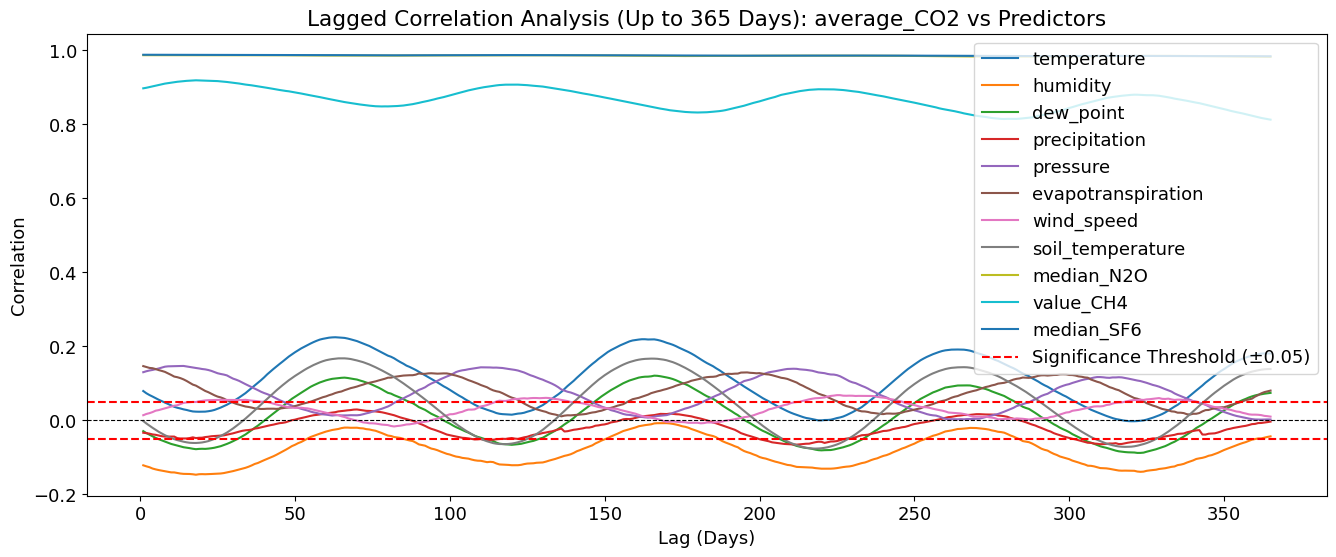

In [43]:
plot_lagged_correlations(df_combined_inner, 'average_CO2', 365)

Key Observations:
🌡 **Temperature** (`temperature_2m (°C)`) shows a periodic pattern
- The correlation peaks at around 90, 180, and 360 days.
- This suggests a seasonal effect, where temperature changes predict CO₂ levels months later.
- Possible explanation: Seasonal cycles of vegetation, ocean uptake, or industrial activity.


💧 **Humidity** (`relative_humidity_2m (%)`) has a weak but noticeable lag effect
- Correlation is slightly negative, meaning higher humidity may be linked to lower CO₂ later.
- This could be due to increased plant growth (photosynthesis) reducing CO₂.


🛑 **N₂O** (`median_N2O`) shows some delayed correlation

- N₂O is related to industrial activity and fossil fuel combustion.
- If N₂O increases, CO₂ might follow due to shared emission sources.


*🔥 **Methane** (`value_CH4`) has a strong positive correlation with CO₂ over time

- CH₄ and CO₂ both contribute to greenhouse effects.
- CH₄ breaks down into CO₂ over time, explaining why higher CH₄ leads to increased CO₂ later.

🌎 **SF₆** (`median_SF6`) shows the strongest overall correlation

- SF₆ is a long-lived greenhouse gas, and its correlation with CO₂ is almost constant. This suggests shared sources or long-term emission trends.

🔬 Interpretation
- Temperature and CH₄ are the strongest predictors of CO₂ over time.
- The delayed effects (~90 to 360 days) explain why Pearson/Kendall correlation missed these relationships.
- There is a clear seasonal component, especially for temperature and humidity.
- Industrial gases (N₂O, SF₆) show long-term trends in relation to CO₂.


### 5 year in the past -  analysis

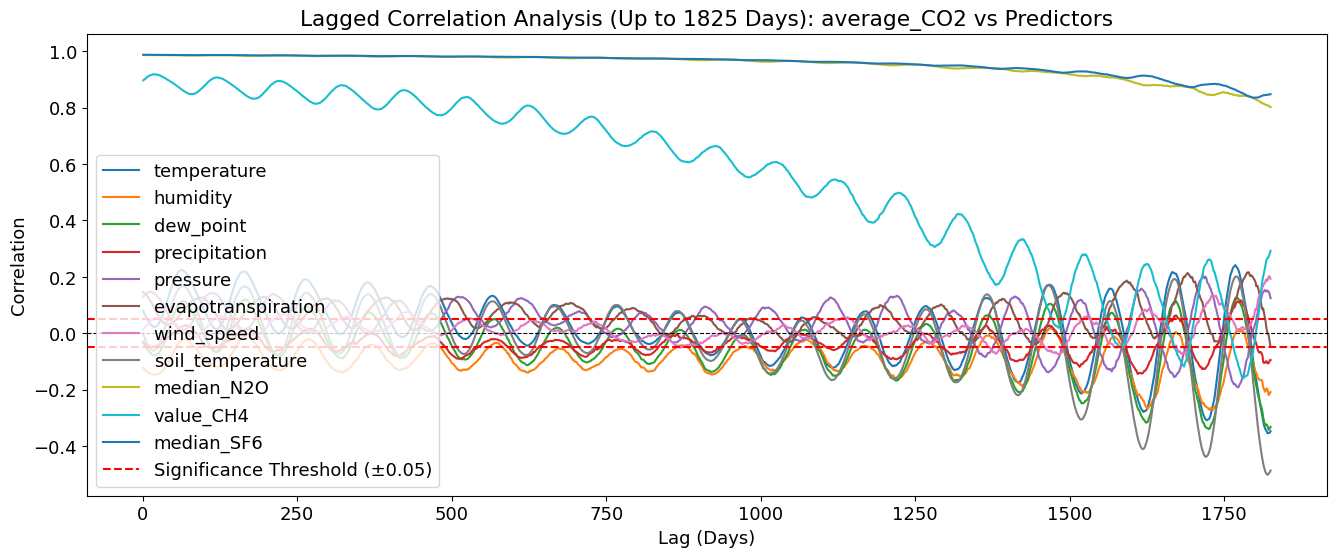

In [44]:
plot_lagged_correlations(df_combined_inner, 'average_CO2', 1825)

📉 Temperature (`temperature_2m (°C)`) shows Strong Multi-Year Cycles
- Clear periodic pattern every ~365 days → Suggests annual climate cycles affecting CO₂.
- Peaks every ~1 year, aligning with seasonal and yearly CO₂ fluctuations.

💧 Humidity (`relative_humidity_2m (%)`) Shows Opposite Cycles
- Correlation oscillates inversely to temperature.
- Suggests that higher humidity is associated with lower future CO₂ levels, likely linked to vegetation absorption and precipitation cycles.

🔥 CH₄ (`value_CH4`) and SF₆ (`median_SF6`) Show Strong Long-Term Correlations - they maintain high correlation for multiple years.

📈 N₂O (`median_N2O`) Shows Long-Term Influence - it maintains a high correlation for several years.

The yearly cycles suggest that seasonality must be considered in CO₂ forecasting models.


### 10 year back analysis

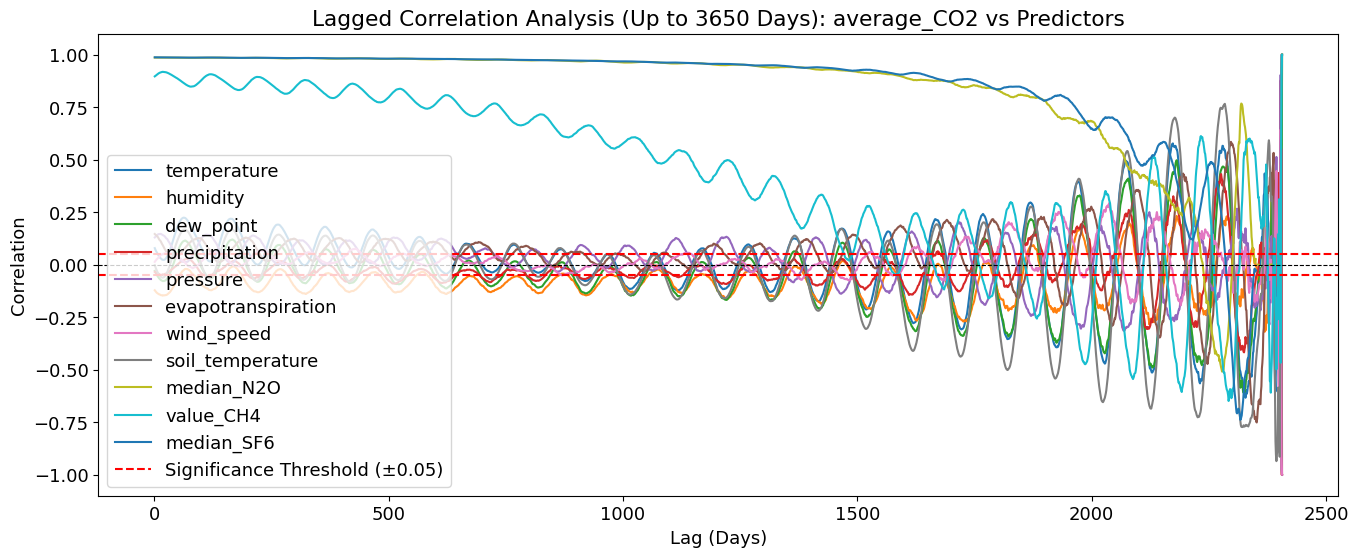

In [45]:
plot_lagged_correlations(df_combined_inner, 'average_CO2', 3650)

🔍 Very Long-Term Lagged Correlation Analysis (10 Years)

This plot extends the lagged correlation window to 10 years (3650 days) to examine even longer-term dependencies between CO₂ and its predictors.

🌡 Temperature (`temperature_2m (°C)`) Shows a Strong Multi-Year Cycle

- Clear oscillations approximately every year (365 days) - suggests strong seasonal and multi-year trends in CO₂.

💧 Humidity (`relative_humidity_2m (%)`) - shows an inverse correlation to temperature.
- Indicates that higher humidity leads to lower CO₂ after several months/years (likely due to enhanced vegetation growth, precipitation, and CO₂ absorption).

🔥 N₂O (`median_N2O`) and SF₆ (`median_SF6`) Maintain Strong Long-Term Correlations

- They consistently correlate with CO₂ across multiple years - suggests shared emission sources or slow accumulation effects over time.

📈 CH₄ (`value_CH4`) Shows a Gradual Decrease in Correlation Over Time

- The influence on CO₂ appears strongest in the first few years but then declines.

📉 After ~8-10 Years, Correlations Become More Unstable

Around 2500-3500 days (7-10 years), the correlations become noisier. This could be due to external climate variability, policy changes, or model limitations in capturing such long-term effects.

🌍 Implications for Long-Term CO₂ Forecasting
- Annual cycles are clearly visible, meaning that any CO₂ forecasting model should incorporate seasonality.
- Humidity has a delayed inverse effect, possibly due to its influence on carbon sinks.
- Industrial pollutants show shorter-term influence, making them more useful for mid-term (1-5 year) forecasting.


In [46]:
df_combined_inner.drop(columns = ['precipitation', 'wind_speed', 'dew_point', 'pressure'])
df_combined_outer.drop(columns = ['precipitation', 'wind_speed', 'dew_point', 'pressure'])
df_full_CO2 = df_combined_outer[['average_CO2']]


In [47]:
df_combined_inner.to_csv('df_combined_inner.csv', index=True)
df_combined_outer.to_csv('df_combined_outer.csv', index=True)
df_full_CO2.to_csv('df_full_CO2.csv', index=True)